In [1]:
#allows to import generator and discriminator
!pip install -q git+https://github.com/tensorflow/examples.git

In [2]:
import tensorflow as tf
#import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
from os import listdir
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from numpy import vstack
from numpy import asarray
from numpy import savez_compressed
import numpy as np
from PIL import Image

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

#AUTOTUNE = tf.data.AUTOTUNE
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
import tensorflow as tf
tf.version.VERSION

'2.5.0'

# Useful methods

In [4]:
# load all images in a directory into memory
def load_images(path, size=(256,256)):
    data_list = list()
    #enumerate filenames in directory, assume all are images
    for filename in listdir(path):
        # load and resize the image
        pixels = load_img(path + filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        # store
        data_list.append(pixels)
    return asarray(data_list)

In [5]:
def generate_images(model, test_input):
    prediction = model(test_input)

    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']
        
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

**Data augmentation techniques**

In [6]:
def random_crop(image):
    cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image

# scaling the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def random_jitter(image):
    # resizing to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)

    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

**Preprocess splits**

In [7]:
def preprocess_image_train(image):
    image = random_jitter(image)
    image = normalize(image)
    return image

def preprocess_image_test(image):
    image = normalize(image)
    return image

**Import and reuse the Pix2Pix models**

In [8]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

**Initializing optimizers, generator and discriminators**

In [9]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Loading generator model

In [10]:
checkpoint_path = "C:/Users/frank/Documents/maestria/propuesta/experiments/models/ck-80/"
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [11]:
ckpt.restore(ckpt_manager.latest_checkpoint)
if ckpt_manager.latest_checkpoint:
    print("Restored from {}".format(ckpt_manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from C:/Users/frank/Documents/maestria/propuesta/experiments/models/ck-80/ckpt-12


In [12]:
generator_g.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, None, 6 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, None, None, 1 131328      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, None, None, 2 524800      sequential_1[0][0]               
______________________________________________________________________________________________

In [13]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [14]:
# frames from video path
path = "/Users/frank/Documents/Tesis/Polipos/DataSet/PolypDatasetProcesed/WL/adenoma_WL/"
# load dataset white light
# here A: white light, B: nbi light
adenoma_WL = load_images(path + 'video_1/')
print("Adenoma WL video_1: ", adenoma_WL.shape)

Adenoma WL video_1:  (175, 256, 256, 3)


In [15]:
adenoma_WL_array = np.asarray(adenoma_WL)
adenoma_WL_ds = tf.data.Dataset.from_tensor_slices(adenoma_WL_array)
adenoma_WL_ds = adenoma_WL_ds.map(preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
                BUFFER_SIZE).batch(BATCH_SIZE)

## **testeando**

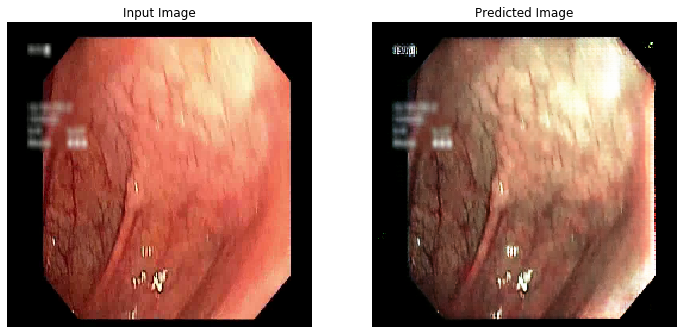

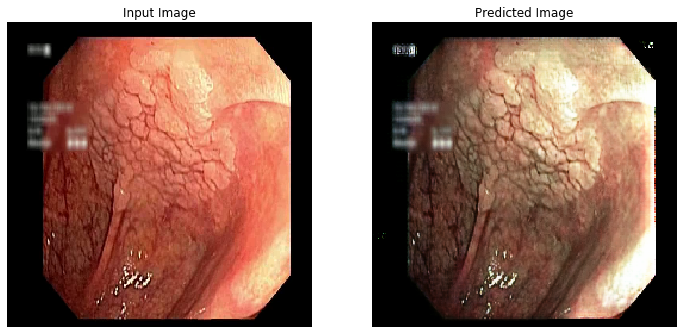

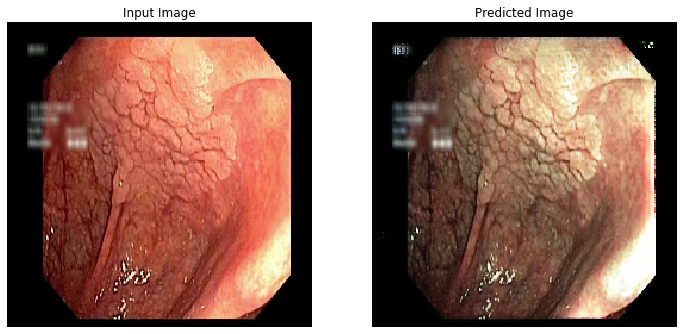

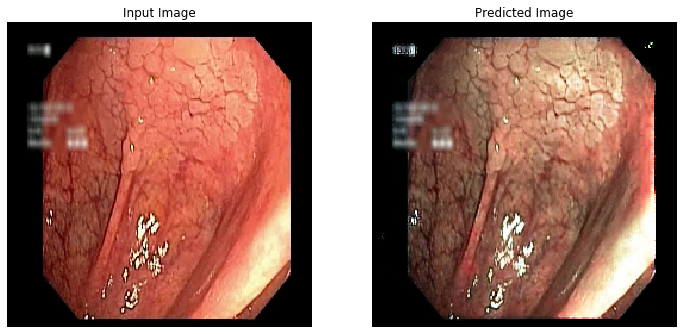

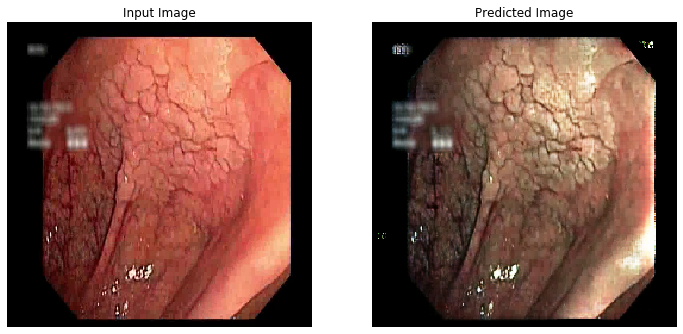

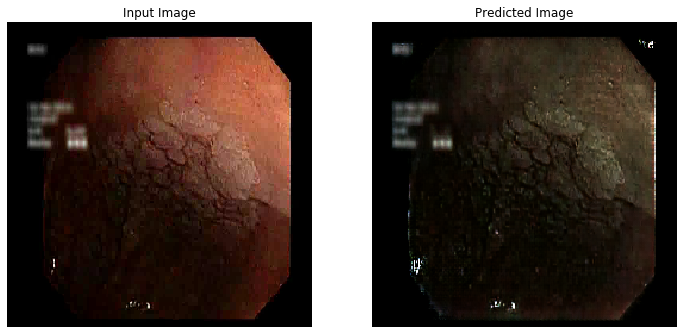

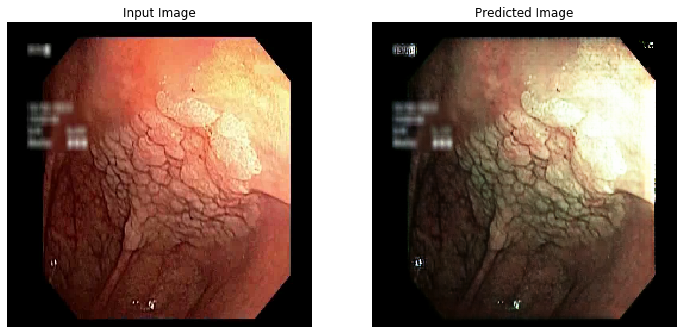

In [16]:
# Run the trained model on the test dataset
for inp in adenoma_WL_ds.take(7):
    generate_images(generator_g, inp)

# Predicting over full frames videos

In [17]:
def generatingImages(data, generator, salve_path):
    
    for count, inp in enumerate(data):
        fake = generator(inp)
        fake = fake[0]* 0.5 + 0.5
        #para que PIL Image deje guardar (mult por 255 and change by uint8)
        fake = np.array(fake) * 255
        fake = fake.astype(np.uint8)
        fake_img = Image.fromarray(fake)
        
        #checking if directory exist
        directory = salve_path.split('/')[:-1]
        directory = "/".join(directory)
        if not os.path.exists(directory):
            os.mkdir(directory)
        
        clase = directory.split('/')[-2:]
        clase = "_".join(clase)
        salve_path = directory + '/' + clase + '_img_' + str(count) + '.png'
        fake_img.save(salve_path)    

In [18]:
def toDataSet(path_origen):
    data = load_images(path_origen)
    print("dimensiones de data: ", data.shape)
    data_array = np.asarray(data)
    data_ds = tf.data.Dataset.from_tensor_slices(data_array)
    data_ds = data_ds.map(preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
                    BUFFER_SIZE).batch(BATCH_SIZE)
    
    return data_ds

In [21]:
# frames from video path
path = '/Users/frank/Documents/Tesis/Polipos/DataSet/PolypDatasetProcesed/WL/'
save = '/Users/frank/Documents/maestria/propuesta/experiments/data/wl2nbi/fake_images_ck80/'
clases = os.listdir(path)
for clase in clases:
    print("========= clase ", clase, "=========")
    clase_pth = path + clase + '/'
    videos = os.listdir(clase_pth)
    for video in videos:
        print("===",video, "====")
        video_pth = clase_pth + video + '/'
        print("convirtiendo a tf.Dataset...")
        data_ds = toDataSet(video_pth)
        imgs = os.listdir(video_pth)
        print("prediciendo con cycleGan...")
        path_save = save + clase + '/' + video + '/'
        generatingImages(data_ds, generator_g, path_save)
            

print("Finalizado!")

========= clase  adenoma_WL =========
=== video_1 ====
convirtiendo a tf.Dataset...
dimensiones de data:  (175, 256, 256, 3)
prediciendo con cycleGan...
=== video_10 ====
convirtiendo a tf.Dataset...
dimensiones de data:  (392, 256, 256, 3)
prediciendo con cycleGan...
=== video_11 ====
convirtiendo a tf.Dataset...
dimensiones de data:  (388, 256, 256, 3)
prediciendo con cycleGan...
=== video_12 ====
convirtiendo a tf.Dataset...
dimensiones de data:  (437, 256, 256, 3)
prediciendo con cycleGan...
=== video_13 ====
convirtiendo a tf.Dataset...
dimensiones de data:  (313, 256, 256, 3)
prediciendo con cycleGan...
=== video_14 ====
convirtiendo a tf.Dataset...
dimensiones de data:  (219, 256, 256, 3)
prediciendo con cycleGan...
=== video_15 ====
convirtiendo a tf.Dataset...
dimensiones de data:  (416, 256, 256, 3)
prediciendo con cycleGan...
=== video_16 ====
convirtiendo a tf.Dataset...
dimensiones de data:  (559, 256, 256, 3)
prediciendo con cycleGan...
=== video_17 ====
convirtiendo a tf

=== video_4 ====
convirtiendo a tf.Dataset...
dimensiones de data:  (480, 256, 256, 3)
prediciendo con cycleGan...
=== video_5 ====
convirtiendo a tf.Dataset...
dimensiones de data:  (146, 256, 256, 3)
prediciendo con cycleGan...
=== video_6 ====
convirtiendo a tf.Dataset...
dimensiones de data:  (336, 256, 256, 3)
prediciendo con cycleGan...
=== video_7 ====
convirtiendo a tf.Dataset...
dimensiones de data:  (316, 256, 256, 3)
prediciendo con cycleGan...
=== video_8 ====
convirtiendo a tf.Dataset...
dimensiones de data:  (328, 256, 256, 3)
prediciendo con cycleGan...
=== video_9 ====
convirtiendo a tf.Dataset...
dimensiones de data:  (395, 256, 256, 3)
prediciendo con cycleGan...
Finalizado!


# Creating video from fake frames predicted

In [3]:
import cv2
import numpy as np
import glob

path = '/Users/frank/Documents/maestria/propuesta/experiments/data/wl2nbi/fake_images_ck80/serrated_WL/video_2/*.png'

img_array = []
for filename in glob.glob(path):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('serV2.avi',cv2.VideoWriter_fourcc(*'DIVX'), 7, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()